In [1]:
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from copy import deepcopy
import scipy.stats as ss
from sklearn.metrics import mean_squared_error as MSE
import os

In [2]:
class Individual:
    def __init__(self,genes,mutation_rate,mutation_scale):
        # a dict describe a individual, with param name as key, parameter value as value
        self.genes   = genes    
        
        # each gene has a probability of mutation_rate to be mutated. Can be a single value for all gens
        # or a dict in which each item for one gene
        self.mutation_rate  = mutation_rate
        
        # The mutation was done by add a random value sampled from N(0,mutation_scale)
        self.mutation_scale = mutation_scale 
    
    def mutate(self):
        for g_ind, gene in self.genes.items():
            p = np.random.uniform()
            if type(self.mutation_scale) == dict: scale = self.mutation_scale[g_ind]
            else: scale = self.mutation_scale
            if p<self.mutation_rate: self.genes[g_ind] = np.random.normal(loc=gene,scale=scale)

In [3]:
def CrossOver(Ind1,Ind2):
    # Ind1 and Ind2 are two parent Individuals
    # CrossOver is done as follows:
    #   (1) Initialize a random vector with a length of genes containing only 0 and 1.
    #   (2) Use genes from Ind1 for zeros and genes from Ind2 for ones
    
    child_genes = dict()
    
    for g_ind in Ind1.genes.keys():
        if np.random.randint(low=0,high=2) == 0: child_genes[g_ind] = Ind1.genes[g_ind] 
        else: child_genes[g_ind] = Ind2.genes[g_ind] 
    
    child_Ind = deepcopy(Ind1)
    child_Ind.genes = child_genes
    
    return child_Ind

In [4]:
def ChooseParents(Individuals,distances):
    # assign weights according to distances, do weighted sampling. The smaller distances, the higher fitness
    # Sample a list of pairs
    # -MSE in fitness_scores
    
    fitness_scores = -np.array(distances)
    
    # normalize fitness scores by substracting the smallest values to make sure all scores are positive
    # score/np.sum(score) as weights
    
    pos_scores = fitness_scores-np.min(fitness_scores)
    weights = pos_scores/np.sum(pos_scores)

    parents = []
    for _ in range(len(Individuals)): 
        pair = list(np.random.choice(Individuals,replace=False,size=2,p=weights))
        parents.append(pair)
    
    return parents

In [5]:
class RV:
    def __init__(self, dist_name,loc,scale):
        '''
        dist_name: 'norm' or 'uniform'
        loc, scale: the same as used in scipy.stats
        '''
        
        self.dist_name = dist_name
        self.loc = loc
        self.scale = scale
        
        if self.dist_name == 'uniform': 
            self.rvf = np.random.uniform
            self.rvf_scale = self.loc + self.scale
            self.pdf = ss.uniform.pdf
        
            
        if self.dist_name == 'normal':
            self.rvf = np.random.normal
            self.rvf_scale = self.scale
            self.pdf = ss.norm.pdf
        
    def rvfv(self):
        '''
        Generate a random sample from the given prior distribution
        '''
        return self.rvf(self.loc,self.rvf_scale)

In [6]:
class GA:
    def __init__(self, model, dist_func, yobs, priors, 
                 population_size, 
                 mutation_rate,
                 mutation_scale,
                 max_ite,
                 min_dist):
        self.model     = model
        self.priors    = priors     # a dict, with parameter name as key, RV instance as value 
        self.dist_func = dist_func
        self.yobs      = yobs
        self.population_size = population_size
        self.mutation_rate   = mutation_rate
        self.mutation_scale  = mutation_scale
        self.max_ite         = max_ite   # maximal iterations 
        self.min_dist        = min_dist  # minimal distance to stop
        self.population      = [None for _ in range(self.population_size)]
        self.distances       = [None for _ in range(self.population_size)]
        
        self.initialize_population()
        #self.all_populations = [self.population]
        self.all_distances = [self.distances]

    def initialize_population(self):
        # Initialize population
        for i in range(self.population_size):
            self.population[i] = Individual(genes= {gid:p.rvfv() for gid,p in self.priors.items()},
                                            mutation_rate = self.mutation_rate,
                                            mutation_scale = self.mutation_scale)
            ypred = self.model(self.population[i].genes)
            self.distances[i] = self.dist_func(self.yobs,ypred)

    def run(self):
        while np.median(self.all_distances[-1])>self.min_dist and len(self.all_distances)<self.max_ite:
            current_population = self.population
            current_distances  = self.distances

            parents = ChooseParents(current_population,current_distances)

            next_population = []
            next_distances = []
            for [dad,mom] in parents:
                child = CrossOver(dad,mom)
                child.mutate()
                next_population.append(child)
                
                ypred = self.model(child.genes)
                
                next_distances.append(self.dist_func(self.yobs,ypred))
            
            
            self.population = next_population
            self.distances  = next_distances
            self.all_distances.append(next_distances)
            print('t{0}:'.format(len(self.all_distances)),np.median(next_distances))

In [7]:
def plot_training_curve(results,outname=None,logy=False):
    its = np.arange(len(results.all_distances))
    D = np.array(results.all_distances)
    media_dist = np.median(D,axis=1)
    
    plt.figure(figsize=(3,2.6))
    plt.scatter(its,media_dist)
    plt.xlabel('Iterations')
    plt.ylabel('Median MSE')
    if logy: plt.yscale('log')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [8]:
def plot_params_bar(true_params,results):
    
    cols = list(true_params.keys())
    cols.sort()
    pos = np.arange(len(true_params))*3
    
    plt.figure(figsize=(10,3))
    plt.bar(pos,[true_params[col] for col in cols],label='True',zorder=1)
    
    plt.bar(pos+1,[np.median([item.genes[col] for item in results.population]) for col in cols],label='Post',zorder=1)
    
    s = len(results.population)
    for i,col in enumerate(cols):
        plt.scatter([pos[i]]*s+np.random.normal(1,0.01,size=s),
                    [item.genes[col] for item in results.population],
                    color='gray',alpha=0.5,s=5,zorder=2)
    plt.legend()
    plt.xlabel('Parameters')
    plt.ylabel('Values')
    plt.show()

### Test 

In [9]:
def run_test():
    def model(param):
        # {'p0':,'p1':,...}
        p = np.array([param['p{0}'.format(i)] for i in range(len(param))])

        res = np.dot(x_exp,np.transpose(p))

        return res
    
    def distance(y_exp,y_pred):
   
        return MSE(y_exp,y_pred)#-np.sum((np.array(y_exp)-y_pred)**2)

    feat_num = 100
    training_samples = 10
    x_exp       = np.random.normal(size=(training_samples,feat_num))
    true_params = {'p{0}'.format(i): np.random.uniform() for i in range(feat_num)}
    y_exp       = model(true_params) + np.random.normal(scale=0.1,size=training_samples)
    
    priors = {'p{0}'.format(i):RV('normal',0,1) for i in range(feat_num)}
    
    exp = GA(model,
         distance,
         y_exp,
         priors,
         population_size=100, 
         mutation_rate=0.1,
         mutation_scale=0.001,
         max_ite=50,
         min_dist=0
         )
    
    exp.run()
    
    plot_params_bar(true_params,exp)
    plot_training_curve(exp)

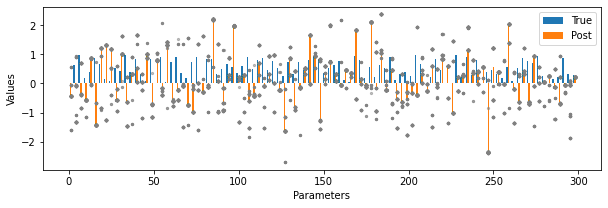

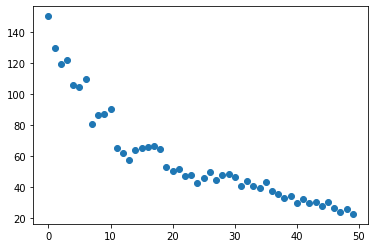

In [10]:
if __name__ == '__main__': run_test()